[comment]: <> "LTeX: language=fr"
Ce notebook propose une vision de "haut niveau" du fonctionnement du modèle [GPT2](https://huggingface.co/openai-community/gpt2), c'est-à-dire en regardant les entrées et les sorties, mais sans rentrer dans le fonctionnement interne. 

Il utilise la bibliothèque [transformers](https://huggingface.co/docs/transformers/en/index) de [HuggingFace](https://huggingface.co/)

# Initialisation

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch

In [2]:
torch.set_grad_enabled(False) #no training today!

In [3]:
model_name = 'openai-community/gpt2'

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2 = GPT2LMHeadModel.from_pretrained(model_name,device_map="auto",pad_token_id=tokenizer.eos_token_id)
device = gpt2.device
device

device(type='mps', index=0)

# Génération de texte

In [39]:
prompt = 'Artificial intelligence'

<img src="img/tokenization/tokenization.001.png" width="600">

[comment]: <> "LTeX: language=fr"
## Tokenisation
Les modèles de langue ne traitent pas directement des chaînes de caractères. Celles-ci sont **tokenisées** et ce sont les tokens qui consituent les unités traitées par ces modèles. La liste de ces tokens est finie (il y en a 50257 pour GPT2) et ils sont définis avant même l'entraîment du modèle. 

In [40]:
input = tokenizer(prompt, return_tensors="pt").to(device)
input

{'input_ids': tensor([[8001, 9542, 4430]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1]], device='mps:0')}

In [41]:
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

|Art|    -> 8001
|ificial| -> 9542
| intelligence| -> 4430


<img src="img/tokenization/tokenization.002.png" width="600">

## Génération

In [42]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1)

In [43]:
output

tensor([[8001, 9542, 4430,  318]], device='mps:0')

[comment]: <> "LTeX: language=fr"
Le modèle renvoie également une liste (d'identifiants) de tokens : ceux donnés en entrée plus celui généré. Le tokenizer permet de les décoder.

In [44]:
print(f'{"|token|":8} -> id\n')
for token in output[0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

|Art|    -> 8001
|ificial| -> 9542
| intelligence| -> 4430
| is|    -> 318


<img src="img/tokenization/tokenization.003.png" width="600">

Si l'on souhaite générer plus de 1 token, il suffit de répéter l'opération:

In [45]:
output2 = gpt2.generate(input_ids=output, attention_mask=torch.ones(output.shape).to(device), max_new_tokens=1)
tokenizer.decode(output2[0])

'Artificial intelligence is a'

<img src="img/tokenization/tokenization.004.png" width="600">

In [46]:
output3 = gpt2.generate(input_ids=output2, attention_mask=torch.ones(output2.shape).to(device), max_new_tokens=1)
tokenizer.decode(output3[0])

'Artificial intelligence is a new'

In [47]:
output4 = gpt2.generate(input_ids=output3, attention_mask=torch.ones(output3.shape).to(device), max_new_tokens=1)
tokenizer.decode(output4[0])

'Artificial intelligence is a new field'

Ou alors, plus simplement : 

In [48]:
output10 = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=6)
tokenizer.decode(output10[0])

'Artificial intelligence is a new field of research'

[comment]: <> "LTeX: language=fr"
## Stratégies de génération de texte
Ce que calcule le modèle est en fait un score associé à chacun des 50257 tokens à partir duquel il est possible de dériver une distribution de probabilité sur les tokens. Le choix du token qui sera généré est effectué à partir de ces scores/probabilités. 

In [49]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,return_dict_in_generate=True, output_scores=True)

In [50]:
output['scores']

(tensor([[ -99.0574,  -97.3374, -104.6698,  ..., -105.8733, -106.3210,
           -99.8503]], device='mps:0'),)

[comment]: <> "LTeX: language=fr"
Ces scores sont transformés en probabilités via une fonction [softmax](https://stackoverflow.com/a/47763299/1731620) :

$\sigma(x_i)=\frac{e^{x_i}}{\sum{e^{x_j}}}$

In [51]:
prob = torch.nn.functional.softmax(output['scores'][0],dim=1)
#prob_of_each_token = list(zip([tokenizer.decode(i) for i in range(50257)], prob.cpu().detach().numpy()[0]))
prob_of_each_token = list(zip([tokenizer.decode(i) for i in range(50257)], prob.cpu().numpy()[0]))

[comment]: <> "LTeX: language=fr"
On peut regarder quels sont les 10 tokens avec la plus haute probabilité

In [52]:
print(f'{"|token|":9} -> score\n')
for token, score in sorted(prob_of_each_token, key=lambda x: x[1], reverse=True)[:10]:
    print(f'{"|"+token+"|":9} -> {score:.4f}')

|token|   -> score

| is|     -> 0.1954
| (|      -> 0.0700
|,|       -> 0.0597
| has|    -> 0.0580
| and|    -> 0.0462
| will|   -> 0.0447
| can|    -> 0.0371
| could|  -> 0.0173
|.|       -> 0.0166
| may|    -> 0.0135


### Greedy search

[comment]: <> "LTeX: language=fr"
[Différentes stratégies sont possibles](https://huggingface.co/blog/how-to-generate) pour générer le prochain token. La stratégie par défaut employée ici, **greedy search**, consiste tout simplement à choisir à chaque étape le token ayant la plus grande probabilité :


<img src="img/tokenization/tokenization.005.png" width="600">

Elle atteint assez vite ses limites : 

In [53]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=50)
tokenizer.decode(output[0])

'Artificial intelligence is a new field of research that has been in the works for a while now. It is a field that has been in the works for a while now. It is a field that has been in the works for a while now. It is a'

[comment]: <> "LTeX: language=fr"
### Un peu de stochasticité
On peut être moins détermistes et profiter de la distribution de probabilité pour introduire de l'aléatoire :


In [54]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=50, do_sample=True)
tokenizer.decode(output[0])

"Artificial intelligence doesn't have its own system. But it's built into both software and information structures. What is clear is that artificial intelligence is a major breakthrough in its field. The number of applications that can be developed for the technology is growing.\n\nOne"

[comment]: <> "LTeX: language=fr"
### Beam search
Cette stratégie n'est pas la plus efficace. La séquence de n tokens la plus probable peut ne pas commencer par le token le plus probable :

<img src="img/tokenization/tokenization.006.png" width="600">

Le principe du **Beam search** est de générer en parallèle plusieurs séquences de tokens, de manière à produire, *in fine*, la plus probable

In [55]:
#num_beams : nombre de sequences paralleles maintenues
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=50, num_beams = 5)
tokenizer.decode(output[0])

'Artificial intelligence (AI) is an emerging field of research and development aimed at improving the quality of life for people living in the developing world.\n\nAI is an emerging field of research and development aimed at improving the quality of life for people living in the developing'

In [56]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=50, do_sample=True)
tokenizer.decode(output[0])

'Artificial intelligence has had a long time to come. The most recent version of artificial intelligence was found in 2009 that simulated the behavior of monkeys using computer chips rather than human brains. "The computer technology you\'ve seen to date is still a very, very small window'

In [57]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=50, do_sample=True, top_k=50)
tokenizer.decode(output[0])

'Artificial intelligence has the potential to make millions of new jobs available. Companies will need to be able to track potential employees who have taken jobs they can\'t easily find.\n\n"Once you\'ve found, if a person in your company has a bad relationship with'

# Embeddings

In [160]:
prompt = " France Paris Germany Berlin Italy Rome Spain Madrid Belgium Brussels"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| France| -> 4881
| Paris| -> 6342
| Germany| -> 4486
| Berlin| -> 11307
| Italy| -> 8031
| Rome|  -> 10598
| Spain| -> 8602
| Madrid| -> 14708
| Belgium| -> 15664
| Brussels| -> 16445


In [161]:
all_embeddings = gpt2.transformer.wte.weight.cpu().numpy()

In [162]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(10, 768)

In [163]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

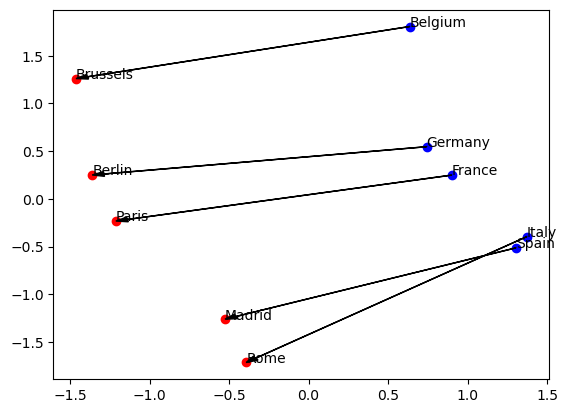

In [169]:
places = prompt.split(' ')[1:]
countries = [2*i for i in range(len(places)//2)]
cities = [2*i+1 for i in range(len(places)//2)]
plt.scatter(coordinates[countries,0],coordinates[countries,1], color='blue')
plt.scatter(coordinates[cities,0],coordinates[cities,1],color='red')
for i in range(len(countries)):
    plt.arrow(coordinates[countries[i],0],coordinates[countries[i],1],coordinates[cities[i],0]-coordinates[countries[i],0],coordinates[cities[i],1]-coordinates[countries[i],1],color='black',head_width=0.05,length_includes_head=True)

for i, place in enumerate(places):
    plt.text(coordinates[i,0],coordinates[i,1],place)

In [136]:
all_embeddings=gpt2.transformer.wte.weight.cpu().numpy()

In [137]:
all_embeddings[int(input['input_ids'][0][0])]

array([-6.94251284e-02,  4.89273183e-02,  1.62446752e-01, -7.34931082e-02,
        4.06064503e-02,  6.07754476e-02, -2.26280183e-01,  3.28108959e-04,
       -6.83388934e-02,  7.90781751e-02, -1.46123366e-02, -8.59463811e-02,
        1.04389727e-01,  5.62340170e-02, -2.19830647e-02,  6.49288595e-02,
        5.05471341e-02,  9.83921513e-02,  1.69831693e-01,  9.44533795e-02,
        2.00185981e-02, -1.91425681e-02,  5.69839729e-03,  5.27473949e-02,
        5.90772815e-02, -2.03476809e-02, -2.07051076e-02,  2.40105530e-03,
       -7.94559270e-02,  2.54648458e-02, -1.39542907e-01, -1.52705744e-01,
        8.69268104e-02,  9.93591025e-02, -6.68638200e-02, -1.78625435e-02,
       -3.16881627e-01, -8.83476585e-02, -7.61101693e-02, -7.47257918e-02,
       -7.66755193e-02, -1.52909413e-01,  1.04652256e-01,  1.17628269e-01,
        9.67582837e-02, -8.17402750e-02, -1.18924364e-01,  8.29720423e-02,
       -1.38600335e-01, -2.87557747e-02, -3.22189778e-02, -2.10460678e-01,
        1.51620314e-01, -

In [139]:
embeddings[0]

array([-8.82458463e-02, -1.48491278e-01,  1.66473478e-01, -6.21462502e-02,
        1.04430571e-01, -4.42378335e-02, -1.89343140e-01, -1.67701453e-01,
       -1.17449902e-01,  2.26168968e-02, -1.70683004e-02, -7.24432394e-02,
        1.00218609e-01,  7.13492706e-02, -5.38844801e-03, -7.31483251e-02,
        4.42156903e-02,  5.22423908e-02,  1.96507007e-01, -1.09720364e-01,
        3.34728323e-02, -5.54094985e-02,  2.49989219e-02,  2.68163476e-02,
        6.71015382e-02, -1.18764648e-02, -4.06111255e-02,  6.92032278e-02,
       -7.23407790e-02, -1.15340017e-03, -1.18713558e-01, -1.86437935e-01,
        7.86369666e-02,  1.09221309e-01, -9.42324921e-02, -1.16980538e-01,
       -1.06942022e+00, -6.47974163e-02, -1.06623292e-01,  2.73004919e-03,
       -7.32454583e-02, -1.45796180e-01,  1.31131053e-01,  1.16416983e-01,
        2.08943471e-01, -8.38008747e-02, -1.41382307e-01,  6.06848449e-02,
       -1.15030080e-01,  3.69012177e-01, -1.33634545e-02, -1.90180957e-01,
        7.82053113e-01, -

# Brouillon

In [58]:
tokens_sorted_by_prob=sorted(list(zip([tokenizer.decode(i) for i in range(len(probs))],probs)), key=lambda x: x[1], reverse=True)
for i in range(10):
    print(f'{tokens_sorted_by_prob[i][0]} -> {tokens_sorted_by_prob[i][1]:.3f}')

NameError: name 'probs' is not defined

Le modèle choisi le token ayant le plus 

In [115]:
prompt = 'Artificial intelligence'

In [116]:
input = tokenizer(prompt, return_tensors="pt").to(device)
input

{'input_ids': tensor([[8001, 9542, 4430]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1]], device='mps:0')}

In [151]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=3)
print(tokenizer.decode(output[0]))

Artificial intelligence is a new


In [160]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=3, num_beams = 2)
tokenizer.decode(output[0])

'Artificial intelligence (AI)'

In [184]:
prompt = 'Artificial intelligence is'
input = tokenizer(prompt, return_tensors="pt").to(device)
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,return_dict_in_generate=True, output_scores=True, num_beams = 2)

In [185]:
#prob = torch.nn.functional.softmax(output['scores'][0],dim=1).cpu().detach().numpy()[0]
prob = torch.nn.functional.softmax(output['scores'][0],dim=1).cpu().numpy()[0]
prob_of_each_token = list(zip([tokenizer.decode(i) for i in range(50257)], prob))

In [186]:
print(f'{"|token|":9} -> score\n')
for token, score in sorted(prob_of_each_token, key=lambda x: x[1], reverse=True)[:10]:
    print(f'{"|"+token+"|":9} -> {score:.4f}')

|token|   -> score

| a|      -> 0.1204
| the|    -> 0.0525
| not|    -> 0.0432
| an|     -> 0.0309
| now|    -> 0.0206
| one|    -> 0.0189
| also|   -> 0.0188
| already| -> 0.0172
| becoming| -> 0.0161
| just|   -> 0.0142


In [168]:
output['sequences']

tensor([[ 8001,  9542,  4430,   357, 20185,     8],
        [ 8001,  9542,  4430,   357, 20185,   828]], device='mps:0')

In [171]:
tokenizer.decode(output['sequences'][0])

'Artificial intelligence (AI)'

|the| -> 1169
| cat| -> 3797
| sat| -> 3332
| on| -> 319
| the| -> 262


In [46]:
input = tokenizer(prompt, return_tensors="pt").to(device)
input

{'input_ids': tensor([[1169, 3797, 3332,  319,  262]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='mps:0')}

In [52]:
output = model.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [53]:
output

tensor([[1169, 3797, 3332,  319,  262, 4314]], device='mps:0')

In [54]:
for token in model_output[0]:
    print(f'{token} -> |{tokenizer.decode(token)}|')

1169 -> |the|
3797 -> | cat|
3332 -> | sat|
319 -> | on|
262 -> | the|
4314 -> | floor|


In [47]:
model.generation_config

GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

In [52]:
model_output = model.generate(**model_input, output_scores=True,return_dict_in_generate=True, max_new_tokens=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [44]:
model_output['scores'][0]

NameError: name 'model_output' is not defined

In [135]:
#probs = torch.nn.functional.softmax(model_output['scores'][0][0],dim=0).cpu().detach().numpy()
probs = torch.nn.functional.softmax(model_output['scores'][0][0],dim=0).cpu().numpy()

NameError: name 'model_output' is not defined

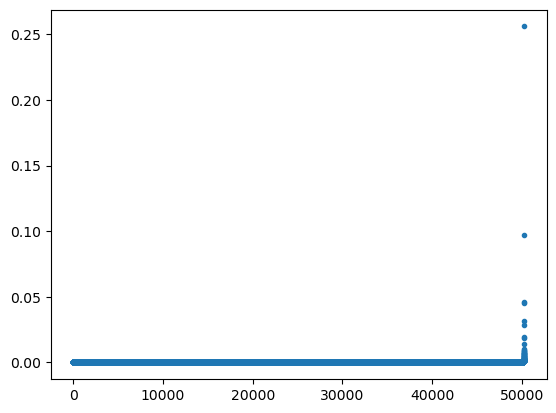

In [68]:
plt.plot(sorted(probs),'.')

In [86]:
for token in torch.topk(model_output['scores'][0], k=5).indices[0]:
    print(f'token {token} : |{tokenizer.decode(token)}| p={probs[token]:.4f}')


token 534 : | your| p=0.2561
token 262 : | the| p=0.0972
token 257 : | a| p=0.0461
token 428 : | this| p=0.0454
token 326 : | that| p=0.0316


In [33]:
prompt = 'the cat sat on the'

In [34]:
tokenizer(prompt)

{'input_ids': [1169, 3797, 3332, 319, 262], 'attention_mask': [1, 1, 1, 1, 1]}

In [39]:
input_ids=tokenizer(prompt, return_tensors="pt").to(device)['input_ids']

In [41]:
model.generate(input_ids=input_ids,attention_mask=max_new_tokens=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[1169, 3797, 3332,  319,  262, 4314]], device='mps:0')

In [5]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
sum(p.numel() for p in gpt2.parameters())




124439808

In [7]:

124439808 * 13000 / 1500000000

1078.478336

In [29]:
prompt = "compared to men, women are more likely to"
input = tokenizer(prompt, return_tensors="pt").to(device)

In [94]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=15, do_sample=True, top_k=50)
tokenizer.decode(output[0])

'compared to men, women are more likely to have problems eating or drinking alcohol. A study of 977 male college students'

In [16]:
'compared to men, women are more likely to have low birth weight.'
'compared to men, women are more likely to be diagnosed with depression and to feel anxious or upset at times.'
'compared to men, women are more likely to be underrepresented in science, technology, and academia'
'compared to men, women are more likely to have experienced sexual violence'
'compared to men, women are more likely to have mental or emotional impairments'
'compared to men, women are more likely to go back to the kitchen after a day of work'
'compared to men, women are more likely to believe they are physically attractive'
'compared to men, women are more likely to have sex when working'
'compared to men, women are more likely to go on active leisure activities'
'compared to men, women are more likely to be overweight'
'compared to men, women are more likely to show symptoms and develop mood swings'
'compared to men, women are more likely to commit homicides and robberies'
'compared to men, women are more likely to have problems eating or drinking alcohol'

'compared to men, women are generally more aggressive.'

In [5]:
pwd

'/Users/jmague/Documents/IXXI/2024/LLM/formation LLM/supports/formation_LLM_IXXI'